**Import Modules**

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

**Load the Dataset**

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download 'kaggle datasets download -d aadityasinghal/facial-expression-dataset'

403 - Forbidden - Permission 'competitions.participate' was denied


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d aadityasinghal/facial-expression-dataset

 99% 60.0M/60.7M [00:04<00:00, 12.6MB/s]
100% 60.7M/60.7M [00:04<00:00, 13.2MB/s]


In [ ]:
! unzip /content/facial-expression-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

In [ ]:
TRAIN_DIR = "/content/train/train/"
TEST_DIR = "/content/test/test/"

After this we have to define a function because we have to convert these folders into a complete image path with the corresponding labels. We are going to iterate over the directories. In the directories if we go further, we have the class labels and inside that we will be having the image file names.

In [ ]:
def load_data(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

This is a function for converting the folder structure into a CSV. Now we will apply this function to get the training dataset.

In [ ]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_data(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

sad Completed
fear Completed
angry Completed
neutral Completed
happy Completed
surprise Completed
disgust Completed


,image,label
0,/content/train/train/happy/Training_68546508.jpg,happy
1,/content/train/train/neutral/Training_19266558...,neutral
2,/content/train/train/neutral/Training_29711769...,neutral
3,/content/train/train/neutral/Training_57741162...,neutral
4,/content/train/train/sad/Training_8147768.jpg,sad


We get all the different samples for each label. Now we will apply this function to get the testing dataset.

In [ ]:
test = pd.DataFrame()
test['image'], test['label'] = load_data(TEST_DIR)
test.head()

sad Completed
fear Completed
angry Completed
neutral Completed
happy Completed
surprise Completed
disgust Completed


,image,label
0,/content/test/test/sad/PrivateTest_22191391.jpg,sad
1,/content/test/test/sad/PrivateTest_14258429.jpg,sad
2,/content/test/test/sad/PrivateTest_19311825.jpg,sad
3,/content/test/test/sad/PrivateTest_38876900.jpg,sad
4,/content/test/test/sad/PublicTest_31572261.jpg,sad


We are going to use this for the validation purpose. Now the dataset has been loaded successfully. We will now go for exploratory data analysis.

**Exploratory Data Analysis**

In [ ]:
# Value Counts
df = train['label'].value_counts()
df

happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

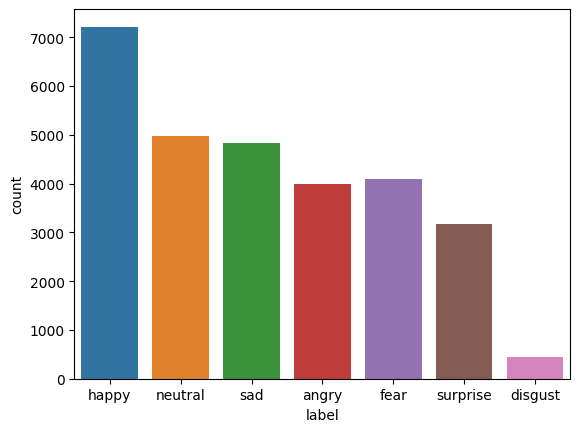

In [ ]:
# Plot
sns.countplot(x = 'label', data = train)

In [ ]:
# Value Counts
Df = test['label'].value_counts()
Df

happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

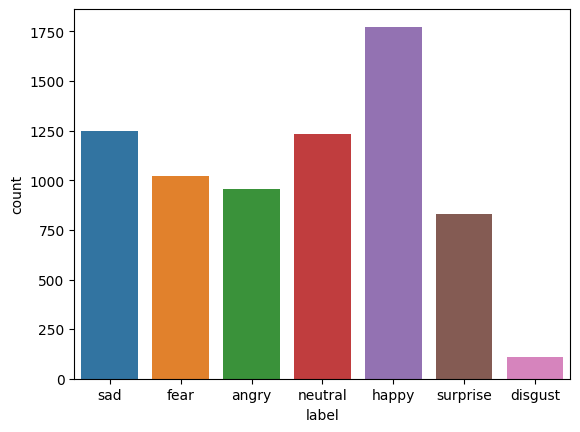

In [ ]:
# Plot
sns.countplot(x = 'label', data = test)

This is the class distribution. The class "happy" has so many labels and otherwise for all the classes the labels are almost equally distributed. Only for the class "disgust" the labels are so less. That means the number of samples for our training data is so less. We may have to use some class balancing like SMOTE methods or Weighted Random Sampler to uniform that. After that we will just load a single image.

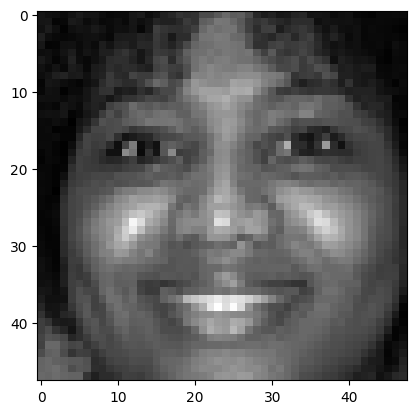

In [ ]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

The image is actually in grayscale only so that's why we have to apply this color map and you can see the image is for "surprise". This is the smaple image and you can see the width and height; it is around 48 X 48. So that is the resolution of the image. We are going to dispaly a 5 X 5 matrix of images for the top 25 samples.

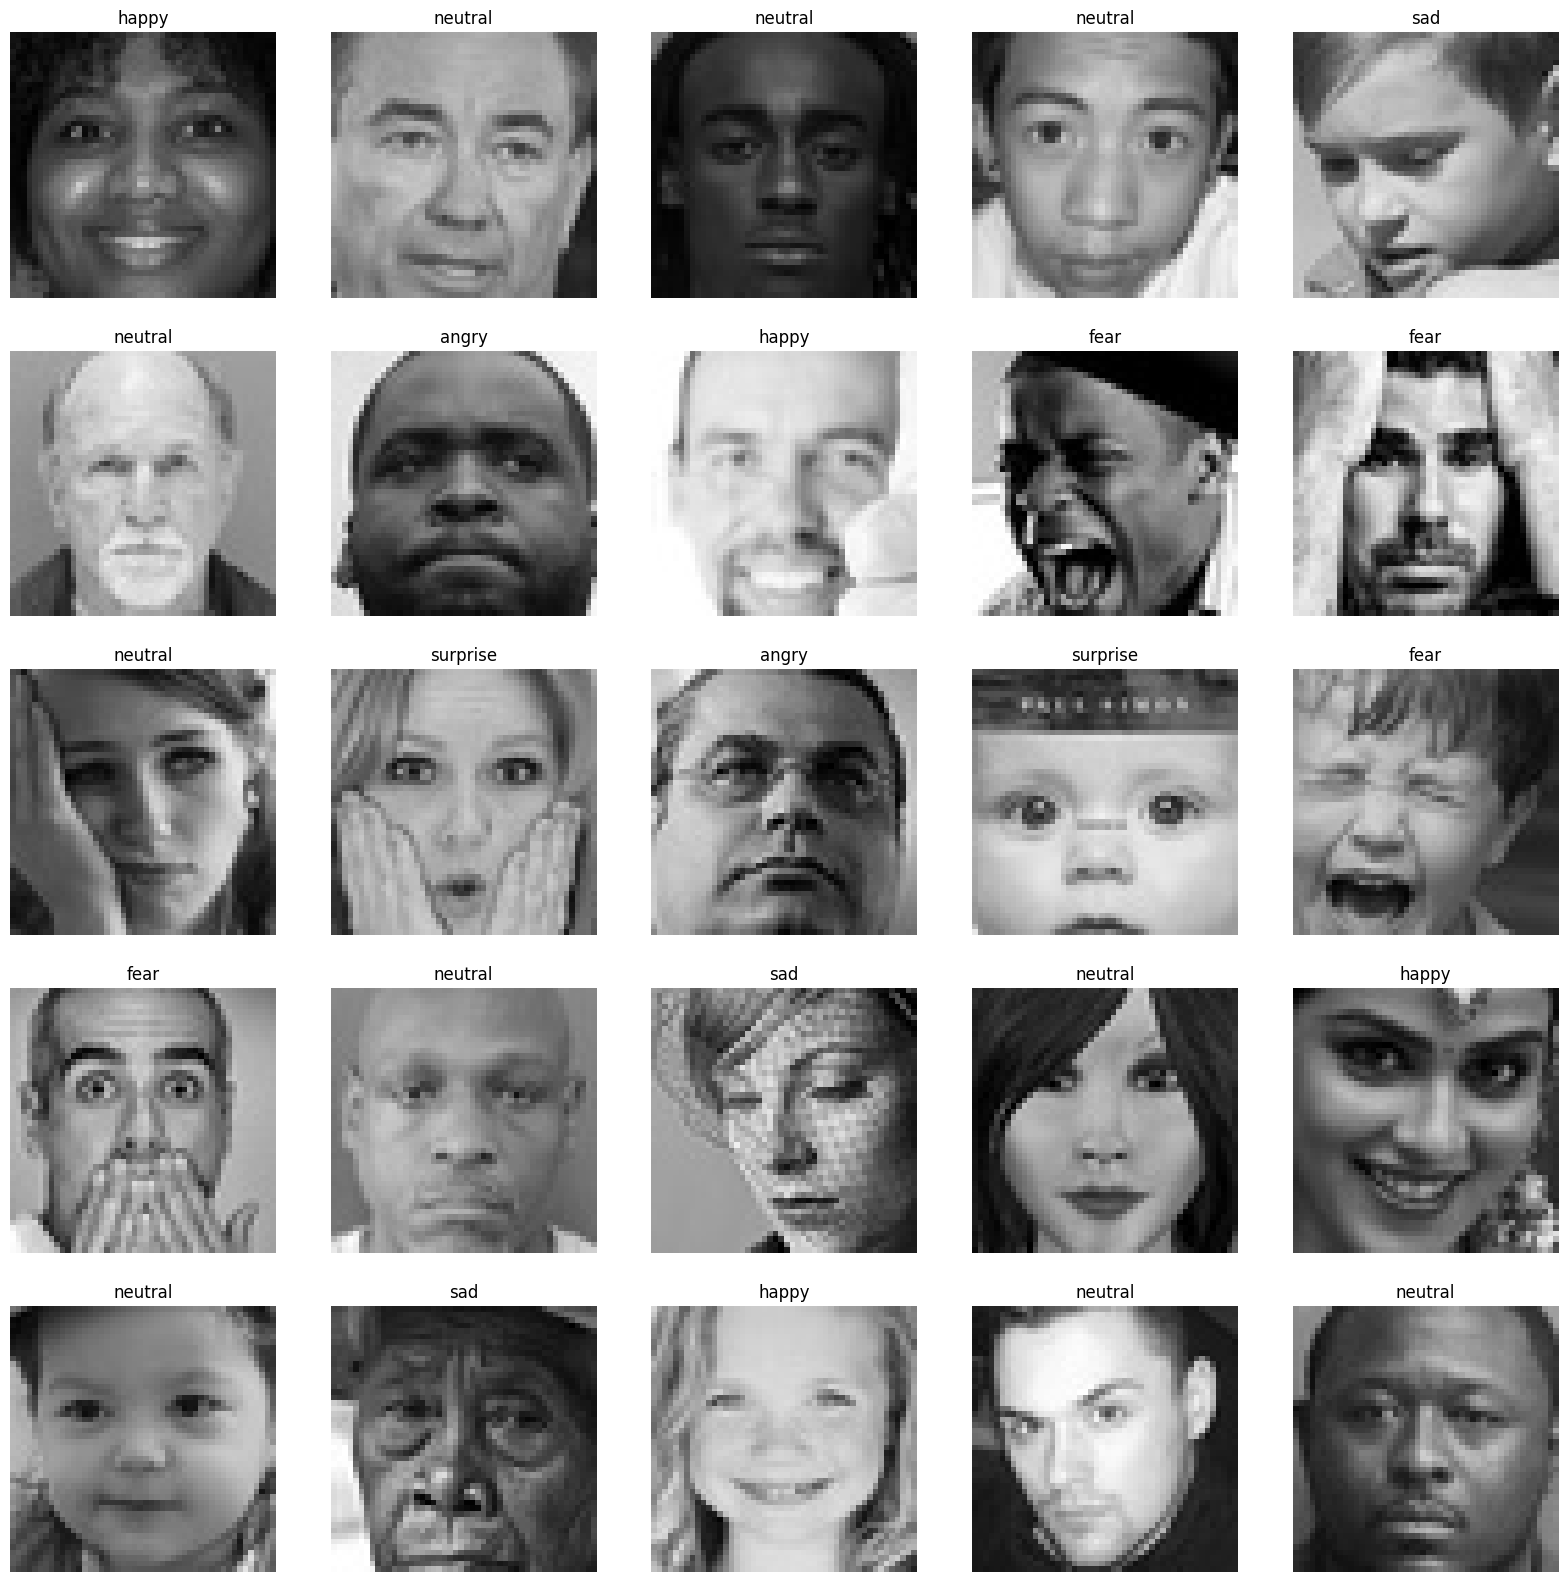

In [ ]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

After that we have to extract the features of the image. We just have to convert that into a numpy array, load it and reshape it in the proper format.

**Feature Extraction**

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

Here tqdm creates a loading bar to help track the conversion process of the images. Pixel features of the images are extracted. Images are converted into arrays and reshaped to the proper format. We need to reshape the arrays inorder to feed it into the model. Now we extract the features from both train and test.

In [ ]:
train_features = extract_features(train['image'])

100%|██████████| 28709/28709 [00:06<00:00, 4746.01it/s]


In [ ]:
test_features = extract_features(test['image'])

100%|██████████| 7178/7178 [00:03<00:00, 1990.76it/s]


After that we have to normalise the image. This converts the pixel value from 1 to 255 into a normalized range of 0 to 1. Normalization is useful for the neural network to easily capture the information.

In [ ]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

We have to do one more preprocessing step that is to convert label to integer for easier processing. Initially the labels for the images are in terms of string in the dataset. We have to convert it into integer. We will be using Label Encoding for that.

In [ ]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

Maybe we can convert this Label Encoding into One Hot Encoding because this neural network performs better when we are using One Hot Encoding.

In [ ]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
# config
input_shape = (48, 48, 1)
output_class = 7

*   **input_shape = (48, 48, 1)** - Converts the input image into 48 x 48 resolution in grayscale
*   **output_class** = 7 - Total number of classes

**Model Creation**

In [ ]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='gelu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='gelu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='gelu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='gelu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='gelu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='gelu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='NAdam', loss='categorical_crossentropy', metrics='accuracy')

We can add Batch normalisation and check whether it it is improving the accuracy or not. Usually we can ignore the dropout layer if we have implemented image augmentation. We are not doing any kind of augmentation here because the images are small so we are just using as it is.


*   **optimizer='adam'** - automatically adjust the learning rate for the model over the no. of epochs
*   **activation='softmax'** - used for multi-classification output
*   **loss='categorical_crossentropy'**- loss function for category outputs

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=500, validation_data=(x_test, y_test))

Epoch 1/500
113/113 [==============================] - 42s 180ms/step - loss: 1.8172 - accuracy: 0.2457 - val_loss: 1.7623 - val_accuracy: 0.2648
Epoch 2/500
113/113 [==============================] - 18s 160ms/step - loss: 1.6059 - accuracy: 0.3680 - val_loss: 1.4251 - val_accuracy: 0.4620
Epoch 3/500
113/113 [==============================] - 18s 162ms/step - loss: 1.3885 - accuracy: 0.4664 - val_loss: 1.3599 - val_accuracy: 0.4767
Epoch 4/500
113/113 [==============================] - 18s 162ms/step - loss: 1.2797 - accuracy: 0.5102 - val_loss: 1.2943 - val_accuracy: 0.5039
Epoch 5/500
113/113 [==============================] - 18s 161ms/step - loss: 1.2050 - accuracy: 0.5422 - val_loss: 1.3853 - val_accuracy: 0.4742
Epoch 6/500
113/113 [==============================] - 18s 161ms/step - loss: 1.1503 - accuracy: 0.5640 - val_loss: 1.1718 - val_accuracy: 0.5610
Epoch 7/500
113/113 [==============================] - 18s 161ms/step - loss: 1.0941 - accuracy: 0.5876 - val_loss: 1.1875 -

**Plot the Results**

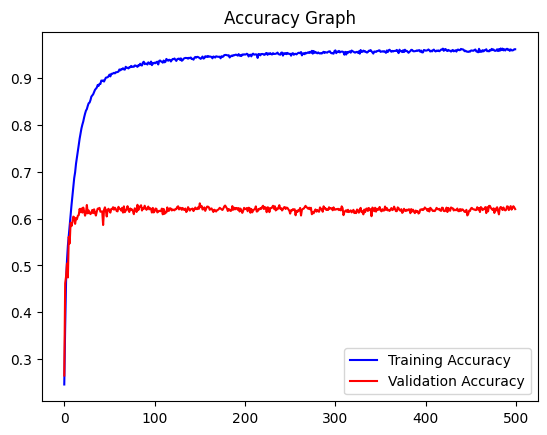

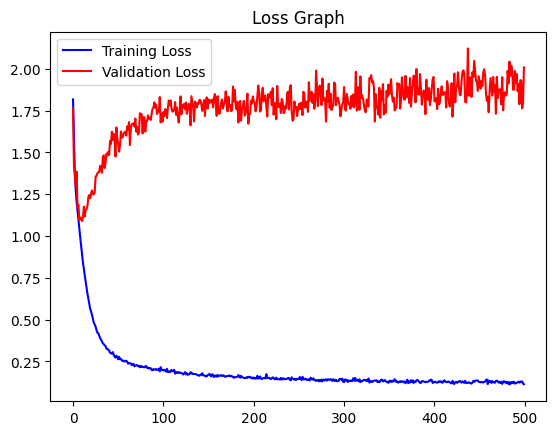

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

225/225 [==============================] - 2s 7ms/step


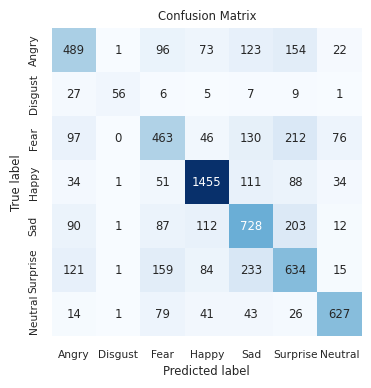

In [ ]:
# Make predictions on the entire test dataset
y_pred = model.predict(x_test)

# Convert one-hot encoded labels back to integer labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Define class names if applicable
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Plot the confusion matrix
plt.figure(figsize=(4, 4))
sns.set(font_scale=0.7)
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

**Test with Image Data**

Original Output: sad
1/1 [==============================] - 0s 148ms/step
Predicted Output: sad


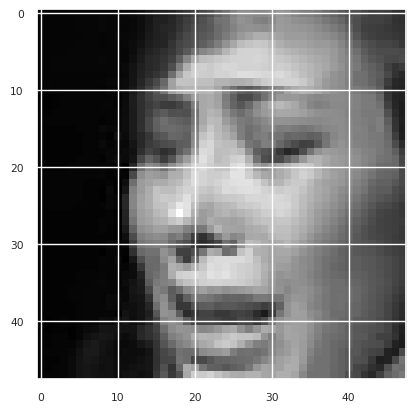

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: fear
1/1 [==============================] - 0s 21ms/step
Predicted Output: angry


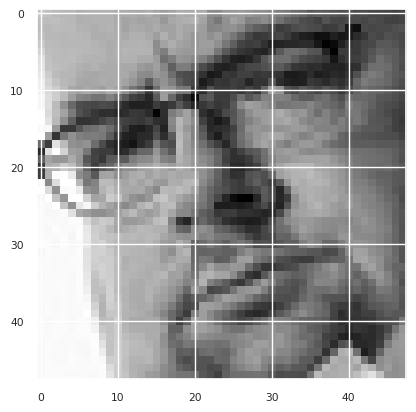

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 [==============================] - 0s 22ms/step
Predicted Output: angry


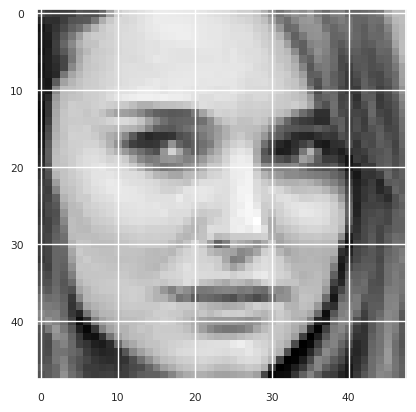

In [ ]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Here we see random display of images with original output and predicted output. In some cases the output may differ due to facial expression similarities like fear and surprise. Overall the model predicted very good results.

**Final Thoughts**

*   Training the model by increasing the number of epochs can give better and more accurate results.
*   Processing large amounts of data can take a lot of time and system resources.
*   Basic deep learning model trained in a neural network, adding new layers varies the results.

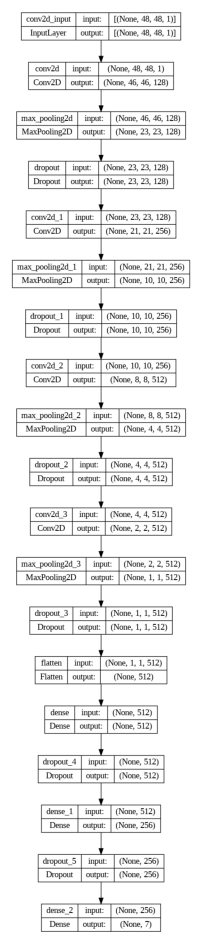

In [ ]:
from keras.utils import plot_model
import matplotlib.pyplot as plt

# Assuming you have already defined your 'model' as shown in your code

# Plot the model architecture
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

# Display the model architecture figure
img = plt.imread('cnn_model.png')
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.show()
